<div align='center'>

# Ordinary Differential Equations (ODEs)

### Part of Scientific-ML-Notes 

[![GitHub](https://img.shields.io/badge/GitHub-Repository-black?logo=github&scale=5)](https://github.com/mhnaderi/Scientific-ML-Notes)

---

In [1]:
# Always run this cell first to import all necessary libraries and to set up the notebook environment

# Import JAX libraries for numerical computations
import jax.lax as lax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.numpy.linalg as la
from jax import jit, jvp, config

# Enable 64-bit precision in JAX
config.update("jax_enable_x64", True)

import numpy as np
from scipy.linalg import expm
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Configure Matplotlib for inline plotting and LaTeX-style text rendering
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({"font.family": "serif"})
plt.rcParams.update({"figure.facecolor": 'white', "axes.facecolor": 'white'})

# Ordinary Differential Equations (ODEs)

## First-Order ODEs

A general first-order system of ordinary differential equations (ODEs) is expressed as:

$$
\dot{\boldsymbol{y}}(t) = f(t, \boldsymbol{y}),
$$

where:
- $\boldsymbol{y}: \mathbb{R} \rightarrow \mathbb{R}^n$ is the unknown function we aim to find,
- $f: \mathbb{R} \times \mathbb{R}^n \rightarrow \mathbb{R}^n$ is a given function,
- $\dot{\boldsymbol{y}} = \dfrac{d\boldsymbol{y}}{dt}$ denotes the derivative of $\boldsymbol{y}$ with respect to time $t$.

To uniquely determine the solution, we require an initial condition (IC) of the form $\boldsymbol{y}(t_0) = \boldsymbol{y}_0$. This setup constitutes an initial value problem (IVP), where the initial condition ensures a unique solution to the ODE.

### Existence and Uniqueness of Solutions

The behavior of the solution heavily depends on the properties of the function $f$. A fundamental requirement is that $f$ satisfies the Lipschitz condition with respect to $\boldsymbol{y}$ in a given vector norm $\|\cdot\|$:

$$
\| f(t, \boldsymbol{x}) - f(t, \boldsymbol{y}) \| \leq \lambda \| \boldsymbol{x} - \boldsymbol{y} \|, \quad \text{for all } \boldsymbol{x}, \boldsymbol{y} \in \mathbb{R}^n, \quad t \geq t_0.
$$

Here, $\lambda > 0$ is the Lipschitz constant, independent of the choice of $\boldsymbol{x}$ and $\boldsymbol{y}$. This condition implies that $f$ does not change too rapidly with respect to $\boldsymbol{y}$; specifically, the rate at which $f(t, \boldsymbol{x})$ approaches $f(t, \boldsymbol{y})$ as $\boldsymbol{x} \rightarrow \boldsymbol{y}$ is bounded by $\lambda$.

If $f(t, \boldsymbol{y})$ is continuously differentiable with respect to $\boldsymbol{y}$ on a closed set $D \subseteq \mathbb{R}^n$, then $f$ is Lipschitz continuous on $D$. Under the Lipschitz condition, the ODE system is guaranteed to have a unique solution.

### Convergence and Order of Numerical Methods

A numerical method is considered **convergent** if, for every ODE with a Lipschitz continuous function $f$ and any $t^* > 0$, the following holds:

$$
\lim_{h \rightarrow 0^+} \max_{n = 0, 1, \ldots, \left\lfloor \dfrac{t^*}{h} \right\rfloor} \left\| \boldsymbol{y}_{n,h} - \boldsymbol{y}(t_n) \right\| = 0,
$$

where:
- $\boldsymbol{y}_{n,h}$ is the numerical approximation of $\boldsymbol{y}(t_n)$,
- $h$ is the step size,
- $t_n = t_0 + n h$,
- $\left\lfloor \alpha \right\rfloor$ denotes the integer part of $\alpha$.

This means that as the grid becomes finer (smaller $h$), the numerical solution approaches the true solution uniformly over the interval $[t_0, t^*]$.

A numerical method has a **local truncation error** of order $p$ if:

$$
\boldsymbol{y}(t_{n+1}) - \mathcal{Y}_n\left( f, h, \boldsymbol{y}(t_n) \right) = \mathcal{O}\left( h^{p+1} \right),
$$

for every analytic function $f$ and for all $n = 0, 1, \ldots$. Here, $\mathcal{Y}_n$ represents the numerical method's approximation at step $n+1$. The order $p$ indicates that the error incurred in a single step is proportional to $h^{p+1}$ when $h$ is sufficiently small.

While local error provides information about the method's behavior over a single step, our main interest lies in the **global behavior** over a fixed interval as $h \rightarrow 0$. Although the local error decreases as $\mathcal{O}\left( h^{p+1} \right)$, the number of steps increases as $\mathcal{O}\left( h^{-1} \right)$. Intuitively, one might expect the global error to decrease as $\mathcal{O}\left( h^{p} \right)$. However, this does not hold universally for all numerical methods without satisfying additional conditions.

### Autonomous and Homogeneous ODEs

An **autonomous ODE** is one where the function $f$ does not explicitly depend on the independent variable $t$:

$$
\dot{\boldsymbol{y}} = f(\boldsymbol{y}).
$$

For example:
- $\dot{\boldsymbol{y}} = \boldsymbol{y}^2$ is autonomous.
- $\dot{\boldsymbol{y}} = \boldsymbol{y}^2 + t$ is not autonomous.

Autonomous ODEs are prevalent in many applications and are often simpler to analyze due to their time-invariant nature.

A **homogeneous ODE** is a differential equation where the right-hand side is equal to zero:

$$
\dot{\boldsymbol{y}} = 0.
$$

Homogeneous equations are essential in understanding the intrinsic properties of systems without external forces or inputs.

### Linear ODEs

A linear system of differential equations can be represented in matrix form as:

$$
\dot{\boldsymbol{y}} = \mathbf{A} \boldsymbol{y},
$$

where $\mathbf{A}$ is a constant $n \times n$ matrix of coefficients. If $\mathbf{A}$ is diagonalizable, that is, if there exists a matrix $\mathbf{X}$ such that:

$$
\mathbf{A} = \mathbf{X} \boldsymbol{\Lambda} \mathbf{X}^{-1},
$$

where $\boldsymbol{\Lambda}$ is a diagonal matrix of eigenvalues, then the solution to the system is:

$$
\boldsymbol{y}(t) = e^{\mathbf{A} t} \boldsymbol{y}(0) = \mathbf{X} e^{\boldsymbol{\Lambda} t} \mathbf{X}^{-1} \boldsymbol{y}(0).
$$

Here:
- $e^{\mathbf{A} t}$ is the matrix exponential,
- $\boldsymbol{y}(0)$ is the initial condition.

The system is **stable** if all eigenvalues of $\mathbf{A}$ have negative real parts. In this case:

- $\boldsymbol{y}(t) \rightarrow \mathbf{0}$ as $t \rightarrow \infty$,
- $e^{\mathbf{A} t} \rightarrow \mathbf{0}$ exponentially.

Stability ensures that perturbations or initial discrepancies diminish over time, leading the system to settle to an equilibrium state.

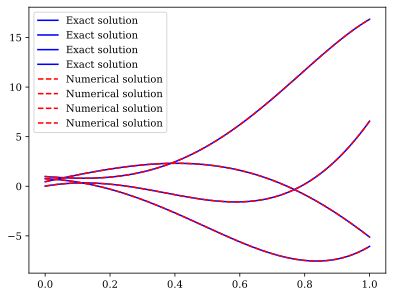

In [2]:
# Define the matrix A
A = np.array([[ 1,  0,  0, -5],
              [ 4, -2,  4, -3],
              [-4,  0,  0,  1],
              [ 5, -2,  2,  3]])

# Initial condition vector u0
u0 = np.random.rand(4,)

# Time span for the ODE solution
tspan = np.linspace(0, 1, 100)

# Define the ODE as a lambda function
f = lambda u, t: A @ u

# Solve the ODE numerically
u = odeint(f, u0, tspan)

# Compute the exact solution using matrix exponentiation
u_exact = np.array([expm(A * t).dot(u0) for t in tspan])

# Plot the exact and numerical solutions
plt.plot(tspan, u_exact, 'b', label='Exact solution')
plt.plot(tspan, u, 'r--', label='Numerical solution')
plt.legend()

## Higher-Order ODEs

A differential equation of order $k$ can be written as:

$$
y^{(k)}(t) = f\left( t, y(t), \dot{y}(t), \ldots, y^{(k-1)}(t) \right),
$$

where $y^{(k)}(t)$ denotes the $k^\text{th}$ derivative of $y$ with respect to $t$.

To convert this higher-order ODE into a system of first-order ODEs, we introduce new variables:

$$
\begin{aligned}
y_1(t) &= y(t), \\
y_2(t) &= \dot{y}(t), \\
&\ \vdots \\
y_{k}(t) &= y^{(k-1)}(t).
\end{aligned}
$$

With these substitutions, the original equation becomes equivalent to the following system of first-order equations:

$$
\begin{cases}
\dot{y}_1(t) = y_2(t), \\
\dot{y}_2(t) = y_3(t), \\
\quad\vdots \\
\dot{y}_{k-1}(t) = y_k(t), \\
\dot{y}_{k}(t) = f\left( t, y_1(t), y_2(t), \ldots, y_k(t) \right).
\end{cases}
$$

In matrix form, this system can be expressed as:

$$
\begin{bmatrix}
\dot{y}_1(t) \\
\dot{y}_2(t) \\
\vdots \\
\dot{y}_{k}(t)
\end{bmatrix} =
\begin{bmatrix}
y_2(t) \\
y_3(t) \\
\vdots \\
f\left( t, y_1(t), y_2(t), \ldots, y_k(t) \right)
\end{bmatrix}.
$$

By transforming the higher-order ODE into this system of first-order equations, we can apply standard methods for analyzing and solving systems of first-order ODEs.

# Explicit Methods

Explicit methods compute the solution at a new time step directly from known information at previous time steps. That is, they progress the solution forward in time using only data from earlier steps without involving the future unknowns in the computations.

## Explicit Euler's Method

For a general system of ordinary differential equations (ODEs) $\boldsymbol{y}' = \boldsymbol{f}(t, \boldsymbol{y})$, the explicit Euler's method approximates the solution by truncating the Taylor series after the first derivative term. The update formula is:

$$
\boldsymbol{y}_{k+1} = \boldsymbol{y}_{k} + h_{k} \boldsymbol{f}(t_{k}, \boldsymbol{y}_{k}),
$$

where $h_{k}$ is the step size at the $k$-th time step.

Key characteristics of Euler's method:

- **Straight-Line Extrapolation:** Advances the solution by extrapolating along a straight line with slope given by $\boldsymbol{f}(t_{k}, \boldsymbol{y}_{k})$.
- **Single-Step Method:** Relies solely on information from the immediate previous time step to proceed.
- **Convergence:** The method is convergent; the numerical solution approaches the exact solution as the step size $h_{k} \rightarrow 0$.
- **First-Order Accuracy:** It is a first-order method because the local truncation error is $\mathcal{O}(h^{2})$, leading to a global error of $\mathcal{O}(h)$.

## Explicit Runge-Kutta (ERK) Methods

One of the most widely used ERK methods is the classical fourth-order Runge-Kutta scheme. It achieves higher accuracy by evaluating the function $\boldsymbol{f}$ at several intermediate points within each time step:

$$
\boldsymbol{y}_{k+1} = \boldsymbol{y}_{k} + \frac{h_{k}}{6} \left( \boldsymbol{k}_1 + 2\boldsymbol{k}_2 + 2\boldsymbol{k}_3 + \boldsymbol{k}_4 \right),
$$

where:

$$
\begin{aligned}
\boldsymbol{k}_1 &= \boldsymbol{f}( t_{k}, \boldsymbol{y}_{k} ), \\
\boldsymbol{k}_2 &= \boldsymbol{f}\left( t_{k} + \dfrac{h_{k}}{2},\ \boldsymbol{y}_{k} + \dfrac{h_{k}}{2} \boldsymbol{k}_1 \right), \\
\boldsymbol{k}_3 &= \boldsymbol{f}\left( t_{k} + \dfrac{h_{k}}{2},\ \boldsymbol{y}_{k} + \dfrac{h_{k}}{2} \boldsymbol{k}_2 \right), \\
\boldsymbol{k}_4 &= \boldsymbol{f}\left( t_{k} + h_{k},\ \boldsymbol{y}_{k} + h_{k} \boldsymbol{k}_3 \right).
\end{aligned}
$$

**Features of the Classical Fourth-Order Runge-Kutta Method:**

- **Higher Accuracy:** It is a fourth-order method, with local truncation error of $\mathcal{O}(h^{5})$ and global error of $\mathcal{O}(h^{4})$.
- **Single-Step Method:** Like Euler's method, it does not require information from multiple previous steps.
- **Widely Used:** Balances computational efficiency with accuracy, making it popular for many applications.

# Multistep Methods

Multistep methods, such as the Adams methods, utilize information from multiple previous time steps to approximate the derivative $\boldsymbol{y}'$ over the integration interval. A general $s$-step method is written as:

$$
\sum_{m=0}^{s} a_{m} \boldsymbol{y}_{n+m} = h \sum_{m=0}^{s} b_{m} \boldsymbol{f}( t_{n+m}, \boldsymbol{y}_{n+m} ), \quad n = 0, 1, 2, \ldots,
$$

where:

- $a_{m}$ and $b_{m}$ are constants independent of $h$, $n$, and the specific differential equation.
- It is conventional to normalize the coefficients by setting $a_{s} = 1$.

**Type of Methods:**

- **Explicit Methods (Adams-Bashforth):** If $b_{s} = 0$, the method is explicit.
- **Implicit Methods (Adams-Moulton):** If $b_{s} \ne 0$, the method is implicit.

**Order and Error:**

- The local truncation error of an $s$-step method is $\mathcal{O}(h^{s+1})$.
- The method is of order $p = s$, implying the global error is $\mathcal{O}(h^{s})$.

# Implicit Methods

Implicit methods compute the solution at a new time step by involving the unknown future value in the computations. This means the solution at time $t_{k+1}$ depends on itself, typically requiring the solution of an algebraic equation at each step.

## Implicit Euler's Method

The implicit Euler's method, also known as the backward Euler method, enhances stability by evaluating the function at the future time step:

$$
\boldsymbol{y}_{k+1} = \boldsymbol{y}_{k} + h_{k} \boldsymbol{f}( t_{k+1}, \boldsymbol{y}_{k+1} ).
$$

**Characteristics:**

- **Implicitness:** The method is implicit because $\boldsymbol{f}$ depends on the unknown $\boldsymbol{y}_{k+1}$.
- **Solving the Implicit Equation:** Typically requires iterative methods like Newton-Raphson or fixed-point iteration to solve for $\boldsymbol{y}_{k+1}$.
  - A good initial guess can be obtained from an explicit method or the previous solution $\boldsymbol{y}_{k}$.
- **Stability:** Offers a significantly larger stability region than explicit methods.
  - **Unconditionally Stable:** The backward Euler method is stable for any positive step size $h_{k}$.
  - This allows for larger step sizes constrained mainly by the desired accuracy.

**Limitations:**

- **First-Order Accuracy:** Despite its stability, it is only first-order accurate, with local truncation error of $\mathcal{O}(h^{2})$.
- **Implicitness Not a Guarantee:** Implicitness alone does not ensure stability for all methods.

## Trapezoidal Method

The trapezoidal method achieves second-order accuracy by averaging the function values at the current and next time steps:

$$
\boldsymbol{y}_{n+1} = \boldsymbol{y}_{n} + \dfrac{h}{2} \left[ \boldsymbol{f}( t_{n}, \boldsymbol{y}_{n} ) + \boldsymbol{f}( t_{n+1}, \boldsymbol{y}_{n+1} ) \right].
$$

**Key Points:**

- **Second-Order Accuracy:** Local truncation error is $\mathcal{O}(h^{3})$, leading to a global error of $\mathcal{O}(h^{2})$.
- **Implicit Method:** Requires solving for $\boldsymbol{y}_{n+1}$ at each step.
- **Convergence:** It is a convergent and single-step method.

## Backward Differentiation Formula (BDF) Methods

Backward Differentiation Formulas are implicit multistep methods that approximate derivatives using past solution values. Examples include:

For $s = 2$:

$$
\boldsymbol{y}_{n+2} - \dfrac{4}{3} \boldsymbol{y}_{n+1} + \dfrac{1}{3} \boldsymbol{y}_{n} = \dfrac{2}{3} h \boldsymbol{f}( t_{n+2}, \boldsymbol{y}_{n+2} ),
$$

For $s = 3$:

$$
\boldsymbol{y}_{n+3} - \dfrac{18}{11} \boldsymbol{y}_{n+2} + \dfrac{9}{11} \boldsymbol{y}_{n+1} - \dfrac{2}{11} \boldsymbol{y}_{n} = \dfrac{6}{11} h \boldsymbol{f}( t_{n+3}, \boldsymbol{y}_{n+3} ).
$$

**Convergence:**

- BDF methods are convergent for orders $1 \leq s \leq 6$.
- The practical range of $s$ is sufficient for most applications.

**Advantages:**

- **Local Error Estimates:** Good local error estimates can be determined for adaptive step sizing.
- **Interpolation Efficiency:** Can efficiently provide solution values at points other than the integration points.
- **Effectiveness for Stiff ODEs:** Particularly suitable for stiff differential equations.

**Disadvantages:**

- **Not Self-Starting:** Require initial values from previous steps, which may necessitate other methods to start.
- **Complexity with Variable Step Sizes:** Changing the step size complicates the method due to reliance on equally spaced intervals.
- **Programming Complexity:** More intricate to implement than single-step methods.

**Note:** The highest possible order of an A-stable linear multistep method is 2, known as Dahlquist's second barrier.

# Implicit Runge-Kutta (IRK) Methods

Implicit Runge-Kutta methods generalize explicit Runge-Kutta methods by allowing the intermediate stages to depend implicitly on each other. The general form is:

$$
\begin{aligned}
\boldsymbol{\xi}_{j} &= \boldsymbol{y}_{n} + h \sum_{i=1}^{\nu} a_{j,i} \boldsymbol{f}( t_{n} + c_{i} h, \boldsymbol{\xi}_{i} ), \quad j = 1, 2, \ldots, \nu, \\
\boldsymbol{y}_{n+1} &= \boldsymbol{y}_{n} + h \sum_{j=1}^{\nu} b_{j} \boldsymbol{f}( t_{n} + c_{j} h, \boldsymbol{\xi}_{j} ).
\end{aligned}
$$

- **Coefficients:**
  - $A = [a_{j,i}]$ is a matrix not limited to a lower triangular form (unlike in explicit methods).
  - The conditions $\sum_{i=1}^{\nu} a_{j,i} = c_{j}$ are imposed to achieve a certain order of accuracy.

**Computation:**

- Involves solving a system of $\nu d$ coupled algebraic equations at each step, where $d$ is the dimension of $\boldsymbol{y}$.
- Requires more computational effort compared to explicit methods.

**Advantages:**

- **Stability:** Offer superior stability properties, making them suitable for stiff equations.
- **Order of Accuracy:** Can achieve high-order accuracy.

**Example of a Two-Stage IRK Method:**

$$
\begin{aligned}
\boldsymbol{\xi}_{1} &= \boldsymbol{y}_{n} + \dfrac{h}{4} \left[ \boldsymbol{f}( t_{n}, \boldsymbol{\xi}_{1} ) - \boldsymbol{f}\left( t_{n} + \dfrac{2h}{3}, \boldsymbol{\xi}_{2} \right) \right], \\
\boldsymbol{\xi}_{2} &= \boldsymbol{y}_{n} + \dfrac{h}{12} \left[ 3\boldsymbol{f}( t_{n}, \boldsymbol{\xi}_{1} ) + 5\boldsymbol{f}\left( t_{n} + \dfrac{2h}{3}, \boldsymbol{\xi}_{2} \right) \right], \\
\boldsymbol{y}_{n+1} &= \boldsymbol{y}_{n} + \dfrac{h}{4} \left[ \boldsymbol{f}( t_{n}, \boldsymbol{\xi}_{1} ) + 3\boldsymbol{f}\left( t_{n} + \dfrac{2h}{3}, \boldsymbol{\xi}_{2} \right) \right].
\end{aligned}
$$

**Advantages of Classical Runge-Kutta Methods:**

- **No History Required:** Do not require information from previous steps.
- **Self-Starting:** Begin integration without additional starting procedures.
- **Flexible Step Sizes:** Easy to adjust step sizes during integration.
- **Ease of Implementation:** Relatively straightforward to program.

**Disadvantages of Classical Runge-Kutta Methods:**

- **No Built-In Error Estimate:** Do not provide an error estimate for adaptive step sizing.
- **Inefficiency for Stiff Problems:** May require very small step sizes for stiff ODEs, leading to inefficiency.

# Implicit-Explicit (IMEX) Methods

IMEX methods combine implicit and explicit schemes to handle different components of the ODE system efficiently. They are particularly useful when the system comprises both stiff and non-stiff parts.

**Concept:**

- **Implicit Treatment:** Apply an implicit method to the stiff component to maintain stability.
- **Explicit Treatment:** Use an explicit method for the non-stiff component to save computational effort.

**Applications:**

- **Convection-Diffusion Problems:**
  - **Convection Term:** Treated explicitly due to its non-stiff nature.
  - **Diffusion Term:** Treated implicitly to handle stiffness.
- **Reaction-Diffusion Systems:** Can be effectively approximated using IMEX schemes, improving computational efficiency while preserving stability.

**Benefits:**

- **Efficiency:** Reduces computational cost compared to fully implicit methods.
- **Stability:** Maintains stability for stiff components without excessively small time steps.

# Stiff ODEs

When solving differential equations, we may encounter situations where the solutions converge extremely rapidly, leading to numerical challenges of a different nature. Such equations are referred to as **stiff ODEs**. Stiffness often arises in physical systems where some components evolve on vastly different time scales, or where the time scales are much shorter than the time interval of interest.

A system of ODEs given by $\boldsymbol{y}' = \boldsymbol{f}(t, \boldsymbol{y})$ is considered stiff if the eigenvalues of its Jacobian matrix $J_f$ differ greatly in magnitude, specifically when the ratio $\left| \dfrac{\lambda_{\text{max}}}{\lambda_{\text{min}}} \right| \gg 1$.

The eigenvalues may exhibit:

- **Large negative real parts**, corresponding to strongly **damped** components in the solution.
- **Large imaginary parts**, leading to rapidly **oscillating** components in the solution.

Many numerical methods struggle with stiff ODEs because the rapidly changing components force very small time steps to maintain numerical stability. The stability constraints are determined by these fast components, while the accuracy requirements are set by the slow components. Consequently, the time step size may be more severely limited by stability concerns than by the desired accuracy.

For instance, the Explicit Euler's method performs poorly on stiff ODEs due to stringent stability requirements on the time step size. Conversely, the Backward Euler method is well-suited for stiff problems because it is **unconditionally stable**.

# Stability

In numerical analysis, a method is termed **A-stable** if its stability region includes the entire left half of the complex plane. This property allows us to choose the time step size $h$ based solely on accuracy considerations, particularly for linear systems, without worrying about stability constraints.

The Trapezoidal Rule is an example of an A-stable method, whereas the Explicit Euler's method is not. Because the Trapezoidal Rule is A-stable, it does not require any restrictions on the step size to avoid instability. However, this does not imply that any arbitrary choice of $h$ will suffice. It is still essential to select a step size $h > 0$ small enough to keep the local truncation error within acceptable bounds and to ensure that the numerical solution closely approximates the exact solution.

Nevertheless, with an A-stable method, there is no need to reduce $h$ excessively to prevent unwanted growth of spurious components in the solution.

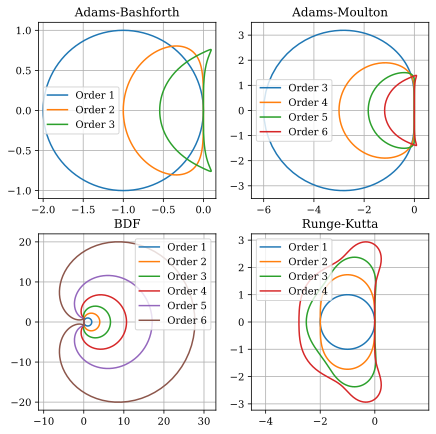

In [5]:
plt.figure(figsize=(7,7))

# Adams-Bashforth
plt.subplot(2,2,1)
z = np.exp(1j*np.pi*np.arange(0,201)/100)
r = z - 1

# Order 1
s = 1
rr = r/s
plt.plot(np.real(rr), np.imag(rr), label='Order 1')

# Order 2
s = (3  -  1/z)/2
rr = r/s
plt.plot(np.real(rr), np.imag(rr), label='Order 2')

# Order 3
s = (23 - 16/z + 5/z**2)/12
rr = r/s
plt.plot(np.real(rr), np.imag(rr), label='Order 3')

plt.axis('equal')
plt.grid('on')
plt.title('Adams-Bashforth')
plt.legend()

# Adams-Moulton
plt.subplot(2,2,2)

# Order 3
s = (5*z + 8 - 1/z)/12
rr = r/s
plt.plot(np.real(rr), np.imag(rr), label='Order 3')

# Order 4
s = (9*z + 19 - 5/z + 1/z**2)/24
rr = r/s
plt.plot(np.real(rr), np.imag(rr), label='Order 4')

# Order 5
s = (251*z + 646 - 264/z + 106/z**2 - 19/z**3)/720
rr = r/s
plt.plot(np.real(rr), np.imag(rr), label='Order 5')

# Order 6
d = 1 - 1/z
s = 1 - d/2 - d**2/12 - d**3/24 - 19*d**4/720 - 3*d**5/160
dd = d/s
plt.plot(np.real(dd), np.imag(dd), label='Order 6')

plt.axis('equal')
plt.grid('on')
plt.title('Adams-Moulton')
plt.legend()

# Backward differentiation formulas (BDF)
plt.subplot(2,2,3)
r = 0
for i in range(1,7):
    r = r + d**i/i
    plt.plot(np.real(r), np.imag(r), label=f'Order {i}')
plt.axis('equal')
plt.grid('on')
plt.title('BDF')
plt.legend()

# Runge-Kutta methods
plt.subplot(2,2,4)

# Order 1
w = 0
W = 1j*np.zeros(len(z))
W[0] = w
for i in range(1, len(z)):
    w = w - (1 + w - z[i])
    W[i] = w
plt.plot(np.real(W), np.imag(W), label='Order 1')

# Order 2
w = 0
W = 1j*np.zeros(len(z))
W[0] = w
for i in range(1, len(z)):
    w = w - (1 + w + 0.5*w**2 - z[i]**2)/(1 + w)
    W[i] = w
plt.plot(np.real(W), np.imag(W), label='Order 2')

# Order 3
w = 0
W = 1j*np.zeros(len(z))
W[0] = w
for i in range(1, len(z)):
    w = w - (1 + w + 0.5*w**2 + w**3/6 - z[i]**3)/(1 + w + 0.5*w**2)
    W[i] = w
plt.plot(np.real(W), np.imag(W), label='Order 3')

# Order 4
w = 0
W = 1j*np.zeros(len(z))
W[0] = w
for i in range(1, len(z)):
    w = w - (1 + w + 0.5*w**2 + w**3/6 + w**4/24 - z[i]**4)/(1 + w + w**2/2 + w**3/6)
    W[i] = w
plt.plot(np.real(W), np.imag(W), label='Order 4')

plt.axis('equal')
plt.grid('on')
plt.title('Runge-Kutta')
plt.legend()

plt.show()

When examining the linear stability regions of multistep methods, the first two figures showcase the stability domains of the Adams methods, all plotted on the same scale for direct comparison. Observing these figures, we notice that the stability regions are quite small and tend to shrink further as the number of steps $s$ increases. Additionally, there's a significant difference between the explicit Adams–Bashforth and the implicit Adams–Moulton methods. While the stability domain of the implicit Adams–Moulton method isn't particularly expansive compared to other methods, it is substantially larger than that of its explicit Adams–Bashforth counterpart. This enlargement partially explains the interest in implicit Adams methods despite their increased computational complexity.

It's important to note that Adams methods were not originally designed to handle stiff equations—problems where solutions exhibit rapid changes requiring specialized numerical approaches. This limitation was a primary motivation for developing backward differentiation formulas (BDFs). Turning to the third figure, which illustrates the linear stability domains for BDF methods, one might expect a significant improvement. Indeed, the stability regions for BDF methods are generally larger than those of the Adams–Moulton methods. However, we find that only the two-step BDF method demonstrates A-stability, meaning its stability region includes the entire left half of the complex plane. Unfortunately, higher-order BDF methods do not maintain this property, which can be disappointing when seeking methods capable of efficiently solving stiff equations.

# Robertson Equations: An Example of a Stiff System

In this section, we will explore the Robertson equations, a well-known example of a stiff system of ordinary differential equations (ODEs). These equations model certain chemical reactions and are notorious for their stiffness, which poses challenges for numerical solvers.

The Robertson equations are given by:

$$
\begin{aligned}
\frac{d y_1}{d t} &= -0.04\, y_1 + 10^4\, y_2\, y_3, \\
\frac{d y_2}{d t} &= 0.04\, y_1 - 10^4\, y_2\, y_3 - 3 \times 10^7\, y_2^2, \\
\frac{d y_3}{d t} &= 3 \times 10^7\, y_2^2.
\end{aligned}
$$

Here:

- $y_1$, $y_2$, and $y_3$ represent the concentrations of chemical species involved in a reaction sequence.
- The large coefficients, such as $10^4$ and $3 \times 10^7$, contribute significantly to the stiffness of the system.

**Stiffness Implications:**

Due to the presence of vastly different time scales (caused by the large coefficients), the Robertson equations are stiff. This means that:

- **Standard Non-Stiff Solvers Fail:** Conventional ODE solvers, especially explicit methods like the explicit Euler or classical Runge-Kutta methods, may fail to solve these equations efficiently.
- **Stability Issues:** Non-stiff solvers may require prohibitively small time steps to maintain numerical stability and accuracy, making computations impractical.
- **Need for Stiff Solvers:** Specialized stiff ODE solvers, such as implicit methods or those specifically designed for stiff systems (e.g., backward differentiation formulas), are necessary to handle the stiffness effectively.

By utilizing appropriate stiff solvers, we can obtain accurate and stable solutions to the Robertson equations without excessive computational cost.

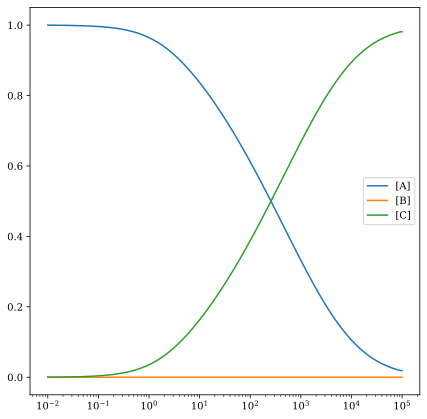

In [4]:
# Select the solver method
SR = "IE"  # Options: "EE", "ERK2", "ERK3", "ERK4", "IE", "AM2", "IRK2", "IRK4"
Nt = 200
eps = 1e-12

# Time span for the ODE solution (log scale from 1e-2 to 1e5)
tspan = jnp.logspace(-2, jnp.log10(1e5), Nt)

# Initial condition vector
y = jnp.array([1.0, 0.0, 0.0])

# Define the system of ODEs
@jit
def f(u):
    k1, k2, k3 = 0.04, 3e7, 1e4
    du_0 = -k1 * u[0] + k3 * u[1] * u[2]
    du_1 = k1 * u[0] - k2 * u[1]**2 - k3 * u[1] * u[2]
    du_2 = k2 * u[1]**2
    return jnp.array([du_0, du_1, du_2])

# Define the solver function
@jit
def Solve(y, dt):
    if SR == "EE":
        F = f(y)
        y += dt * F

    elif SR == "ERK2":
        F1 = f(y)
        F2 = f(y + dt * F1)
        F = (F1 + F2) / 2
        y += dt * F

    elif SR == "ERK3":
        F1 = f(y)
        F2 = f(y + 0.5 * dt * F1)
        F3 = f(y - dt * F1 + 2 * dt * F2)
        F = (F1 + 4 * F2 + F3) / 6
        y += dt * F

    elif SR == "ERK4":
        F1 = f(y)
        F2 = f(y + 0.5 * dt * F1)
        F3 = f(y + 0.5 * dt * F2)
        F4 = f(y + dt * F3)
        F = (F1 + 2 * F2 + 2 * F3 + F4) / 6
        y += dt * F

    elif SR == "IE":
        const = y.copy()

        def Body(l):
            R = const - l[0] + dt * f(l[0])
            fAx = lambda x: x - dt * jvp(f, (l[0],), (x,))[1]
            du = jsp.sparse.linalg.bicgstab(fAx, R)[0]
            return [l[0] + du, du]

        y = lax.while_loop(lambda l: la.norm(l[1]) / y.shape[0] > eps, Body, [y, jnp.ones_like(y)])[0]

    elif SR == "AM2":
        const = y + 0.5 * dt * f(y)

        def Body(l):
            R = const - l[0] + 0.5 * dt * f(l[0])
            fAx = lambda x: x - 0.5 * dt * jvp(f, (l[0],), (x,))[1]
            du = jsp.sparse.linalg.bicgstab(fAx, R)[0]
            return [l[0] + du, du]

        y = lax.while_loop(lambda l: la.norm(l[1]) / y.shape[0] > eps, Body, [y, jnp.ones_like(y)])[0]

    elif SR == "IRK2":
        def Body(l):
            u = l[2] + (1 / 4) * dt * l[0]
            fAx = lambda x: x - (1 / 4) * dt * jvp(f, (u,), (x,))[1]
            dk = jsp.sparse.linalg.bicgstab(fAx, f(u) - l[0])[0]
            return [l[0] + dk, dk, l[2]]

        k1 = lax.while_loop(lambda l: la.norm(l[1]) / y.shape[0] > eps, Body, [f(y), jnp.ones_like(y), y])[0]
        k2 = lax.while_loop(lambda l: la.norm(l[1]) / y.shape[0] > eps, Body, [k1, jnp.ones_like(y), y + (1 / 2) * dt * k1])[0]

        y += (1 / 2) * dt * (k1 + k2)

    elif SR == "IRK4":
        def Body(l):
            u = l[2] + (1 / 4) * dt * l[0]
            fAx = lambda x: x - (1 / 4) * dt * jvp(f, (u,), (x,))[1]
            dk = jsp.sparse.linalg.bicgstab(fAx, f(u) - l[0])[0]
            return [l[0] + dk, dk, l[2]]

        k1 = lax.while_loop(lambda l: la.norm(l[1]) / y.shape[0] > eps, Body, [f(y), jnp.ones_like(y), y])[0]
        k2 = lax.while_loop(lambda l: la.norm(l[1]) / y.shape[0] > eps, Body, [k1, jnp.ones_like(y), y + (1 / 2) * dt * k1])[0]
        k3 = lax.while_loop(lambda l: la.norm(l[1]) / y.shape[0] > eps, Body, [k2, jnp.ones_like(y), y + (17 / 50) * dt * k1 - (1 / 25) * dt * k2])[0]
        k4 = lax.while_loop(lambda l: la.norm(l[1]) / y.shape[0] > eps, Body, [k3, jnp.ones_like(y), y + (371 / 1360) * dt * k1 - (137 / 2720) * dt * k2 + (15 / 544) * dt * k3])[0]
        k5 = lax.while_loop(lambda l: la.norm(l[1]) / y.shape[0] > eps, Body, [k4, jnp.ones_like(y), y + (25 / 24) * dt * k1 - (49 / 48) * dt * k2 + (125 / 16) * dt * k3 - (85 / 12) * dt * k4])[0]

        y += dt * ((25 / 24) * k1 - (49 / 48) * k2 + (125 / 16) * k3 - (85 / 12) * k4 + (1 / 4) * k5)

    return y

# Solve the ODE for each time step
Y = []
for t in range(Nt):
    y = Solve(y, tspan[t + 1] - tspan[t])
    Y.append(y.copy())

# Plot the results
plt.figure(figsize=(7, 7))
plt.plot(tspan, jnp.array(Y)[:, 0], label='[A]')
plt.plot(tspan, jnp.array(Y)[:, 1], label='[B]')
plt.plot(tspan, jnp.array(Y)[:, 2], label='[C]')
plt.xscale('log')
plt.legend()

## Error Control

In the numerical solution of differential equations, maintaining accuracy is paramount. **Error control** refers to the mechanism by which we estimate numerical errors during the computation and adjust the step size accordingly to ensure the desired accuracy is achieved throughout the integration process.

Specifically, error control involves estimating the **local error**, which is the error incurred when advancing the solution from time $t_n$ to $t_{n+1}$ under the assumption that the current value $\boldsymbol{y}_n$ is exact. This local error reflects the discrepancy introduced in a single integration step due to truncation or approximation in the numerical method used.

Estimating the local error is crucial because it allows us to determine whether the current step size $h$ yields an acceptable error level or if it needs to be adjusted. By controlling the local error at each step, we aim to prevent the accumulation of errors that could lead to significant deviations from the true solution.

It's important not to confuse local error with the **global error**, which is the cumulative difference between the numerical solution and the exact solution over all steps up to a certain point. The global error at each time step $n$ is given by:

$$
\text{Global error at } t_n = \boldsymbol{y}_n - \boldsymbol{y}(t_n), \quad n = 0, 1, \ldots, n_{\text{end}}.
$$

Here, $\boldsymbol{y}_n$ is the numerical solution obtained from the method, and $\boldsymbol{y}(t_n)$ is the exact solution evaluated at time $t_n$. While local error measures the error introduced in a single step, the global error represents the total error accumulated up to that point in the integration.

By effectively implementing error control strategies, we can adapt the step size dynamically, ensuring that the numerical solution remains accurate and reliable throughout the computational interval.

## Hamiltonian Systems

A vast number of ordinary differential equation (ODE) systems arising in fields such as mechanics, molecular dynamics, fluid dynamics, quantum mechanics, image processing, celestial mechanics, nuclear engineering, and more can be formulated as Hamiltonian equations:

$$
\begin{aligned}
\boldsymbol{p}' &= -\frac{\partial H(\boldsymbol{p}, \boldsymbol{q})}{\partial \boldsymbol{q}}, \\
\boldsymbol{q}' &= \phantom{-}\frac{\partial H(\boldsymbol{p}, \boldsymbol{q})}{\partial \boldsymbol{p}}.
\end{aligned}
$$

In these equations:

- $H$ is a scalar function known as the **Hamiltonian**, representing the total energy of the system.
- $\boldsymbol{p}$ and $\boldsymbol{q}$ are vector functions, each depending on $d$ variables.
- Typically, $d$ denotes the number of degrees of freedom in the mechanical system.
- $\boldsymbol{q}$ corresponds to the generalized positions, and $\boldsymbol{p}$ corresponds to the generalized momenta.

An important property of Hamiltonian systems is that the Hamiltonian energy $H(\boldsymbol{p}(t), \boldsymbol{q}(t))$ remains constant along the solution trajectory; that is, the total energy is conserved over time.